In [1]:
import matplotlib
matplotlib.use('TkAgg')

import requests
import urllib.request
import keras
import sklearn
import sklearn.cross_validation
import os
import cv2

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

Using Theano backend.


In [23]:
data_dir = Path('../data/unclean')

for page in range(2, 10):
    r = requests.get('https://test.flaunt.peekabuy.com/api/board/get_jc_product_images_batch/?page={}'.format(page))
    image_urls = r.json()['images']
    for url, category, _ in image_urls:
        splits = url.split('/')
        filename = splits[-1]
        filepath = data_dir / filename

        if filepath.exists():
            continue

        urllib.request.urlretrieve(url, str(filepath))
    

In [ ]:
# category_frame = pd.DataFrame(columns=['category', 'filename'])
#         # update the dataframe anyways because we have to rewrite it
#         category_frame = category_frame.append({'filename': filename,
#                                                 'category': category}, ignore_index=True)


In [ ]:
category_frame

In [17]:
category_frame

,category,poo
filename,,


- Do dresses with shirts count as one thing or two things
    - try treating as one piece
- Should clothes with people in them be rejected
    - 
- Should clothes with weird backgrounds (i.e. white on white) be rejected also
    - classify them out
    
    
Do fine-grained annotation but try bucketing / not bucketing the labels

There's a list of labels that should be fed through the existing cropping pipeline and a list that need to be further examined

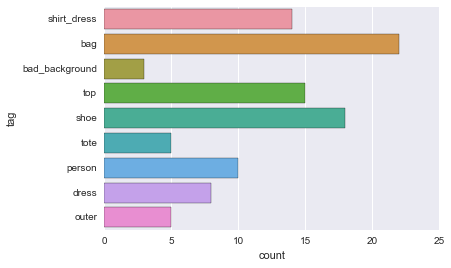

In [56]:
gt_labels = pd.read_csv('../data/raw.csv', header=None, names=['image_name', 'tag'])

sns.countplot(data=gt_labels, y='tag')

num_classes = len(gt_labels.tag.unique())

In [50]:
# fine-grained first pass

# create directory of symlinks
data_path = Path('../data')
train_finegrain_dir = data_path / 'train_finegrain'
test_finegrain_dir = data_path / 'test_finegrain'
if not train_finegrain_dir.exists():
    train_finegrain_dir.mkdir()
    
if not test_finegrain_dir.exists():
    test_finegrain_dir.mkdir()

# generate stratified split
X = gt_labels.image_name
y = gt_labels.tag

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.1, stratify=y)

# symlink train data
for im_name, label in zip(X_train, y_train):
    source_path = (data_path / 'raw' /im_name).resolve()
    dest_path = train_finegrain_dir / label / im_name
    
    class_dir = dest_path.parent
    
    if not class_dir.exists():
        class_dir.mkdir()
    
    if dest_path.exists():
        continue
    
    os.symlink(str(source_path), str(dest_path))
    
# symlink test data
for im_name, label in zip(X_test, y_test):
    source_path = (data_path / 'raw' /im_name).resolve()
    dest_path = test_finegrain_dir / label / im_name
    
    class_dir = dest_path.parent
    
    if not class_dir.exists():
        class_dir.mkdir()
    
    if dest_path.exists():
        continue
    
    os.symlink(str(source_path), str(dest_path))


In [60]:
# train / test generators
train_data_dir = str(train_finegrain_dir)
validation_data_dir = str(test_finegrain_dir)

img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')




Found 100 images belonging to 9 classes.
Found 10 images belonging to 9 classes.


In [62]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 224, 224)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [63]:
model.fit_generator(
        train_generator,
        samples_per_epoch=2000,
        nb_epoch=50,
        validation_data=validation_generator,
        nb_val_samples=800)
model.save_weights('finegrained.h5')

Epoch 1/50
 836/2000 [===========>..................] - ETA: 172s - loss: 2.1517 - acc: 0.2368

KeyboardInterrupt: 

In [4]:
import itertools

def get_class(path):
    if 'clean' == str(path.parent.stem):
        return 'clean'
    else:
        return 'unclean'

# generate train / test split on clean and unclean data
clean_data_path = Path('../data/clean')
unclean_data_path = Path('../data/unclean')

# generate categories
clean_dict = [{str(p): get_class(p) for p in itertools.chain(clean_data_path.glob('*.jpg'), 
                                                       unclean_data_path.glob('*.jpg'))}]

In [5]:
# generate train / test split
clean_frame = pd.DataFrame(clean_dict).transpose()

clean_frame.columns=['is_clean']
clean_frame.index.names = ['filepath', ]

# generate stratified split
X = clean_frame.index
y = clean_frame.is_clean

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.1, stratify=y)


In [9]:
clean_experiment_data = Path('../data/clean_experiment')

if not clean_experiment_data.exists():
    clean_experiment_data.mkdir()
    
clean_experiment_data = clean_experiment_data.resolve()

train_data_dir = clean_experiment_data / 'train'
if not train_data_dir.exists():
    train_data_dir.mkdir()


test_data_dir = clean_experiment_data / 'test'
if not test_data_dir.exists():
    test_data_dir.mkdir()


# symlink train data
for path in X_train:
    source_path = Path(path).resolve()

    label, filename = source_path.parts[-2:]
        
    dest_path = train_data_dir / label / filename    
    
    class_dir = dest_path.parent
    
    if not class_dir.exists():
        class_dir.mkdir()
    
    if dest_path.exists():
        continue
            
    os.symlink(str(source_path), str(dest_path))

# symlink test data
for path in X_test:
    source_path = Path(path).resolve()

    label, filename = source_path.parts[-2:]
        
    dest_path = test_data_dir / label / filename    
    
    class_dir = dest_path.parent
    
    if not class_dir.exists():
        class_dir.mkdir()
    
    if dest_path.exists():
        continue
    
    os.symlink(str(source_path), str(dest_path))

    


In [17]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 150, 150)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
# train / test generators
train_data_dir = str(train_data_dir)
validation_data_dir = str(test_data_dir)

img_height = 150
img_width = 150

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')



Found 362 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


In [ ]:
# train this 
model.fit_generator(
        train_generator,
        samples_per_epoch=2000,
        nb_epoch=50,
        validation_data=validation_generator,
        nb_val_samples=800)
model.save_weights('clean_unclean.h5')

Epoch 1/50
1970/2000 [============================>.] - ETA: 2s - loss: 0.6574 - acc: 0.7142

/Users/chris/projects/peekabuy/env/lib/python3.4/site-packages/keras/engine/training.py:1432: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2002/2000 [==============================] - 180s - loss: 0.6535 - acc: 0.7163 - val_loss: 0.3029 - val_acc: 0.9026
Epoch 2/50
2012/2000 [==============================] - 175s - loss: 0.4719 - acc: 0.7982 - val_loss: 0.2423 - val_acc: 0.9260
Epoch 3/50
2002/2000 [==============================] - 184s - loss: 0.4199 - acc: 0.8302 - val_loss: 0.2762 - val_acc: 0.8767
Epoch 4/50
2012/2000 [==============================] - 196s - loss: 0.3269 - acc: 0.8603 - val_loss: 0.3177 - val_acc: 0.8533
Epoch 5/50
1150/2000 [================>.............] - ETA: 68s - loss: 0.3226 - acc: 0.8739

- look at the filters, the performance is better than I thought
- since it's mostly some function of average color this isn't too surprising

some overfitting

strong overfitting

put in some weight decay or something to pump it up

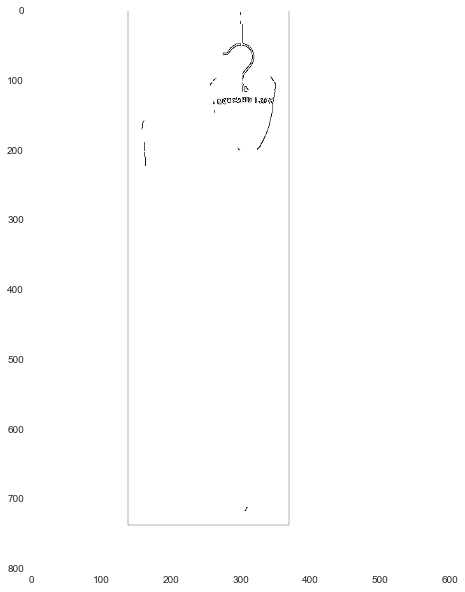

In [106]:
# simple bounding box doer
test_image_filename = '7c2e0159e68207a35a8ff69238cf63ae.jpg'
test_image_path = (Path('../data/raw') / test_image_filename).resolve()

test_image = cv2.imread(str(test_image_path))
gray_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

edges = auto_canny(gray_image)


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, aspect='equal')
ax1.imshow(edges)

box = cv2.boundingRect(edges)

pad = 20

ax1.add_patch(
    patches.Rectangle(
        (box[0] - pad, box[1] - pad),   # (x,y)
        box[2] + 2*pad,          # width
        box[3] + 2*pad,          # height
        fill=False
    )
)

# im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# plt.figure(figsize=(10,10))
# plt.imshow(im2)

In [163]:
test_images = list(Path('../data/raw').glob('*.jpg'))
out_dir = Path('../data/simpleboxes')

if not out_dir.exists():
    out_dir.mkdir()
    
pad = 5
    
boxes = {}
for image_path in test_images:
    key = image_path.parts[-1]
    test_image = cv2.imread(str(image_path))
    gray_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

    edges = auto_canny(gray_image)
    
    x, y, w, h = cv2.boundingRect(edges)
    
    # draw on the image and then save it to the output place
    
    
    x1 = np.clip(x - pad, 0, None)
    y1 = np.clip(y - pad, 0, None)
    x2 = np.clip(x + w + pad, None, test_image.shape[1])
    y2 = np.clip(y + h + pad, None, test_image.shape[0])
    
    
    cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    cv2.imwrite(str(out_dir / key), test_image)
